# 非阻塞IO(non-blocking IO)

Linux下，可以通过设置socket使其变为non-blocking。当对一个non-blocking socket执行读操作时，流程是这个样子：

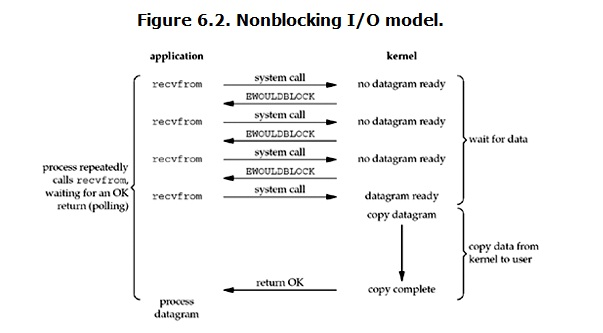
1. </br>

- 从图中可以看出，当用户进程发出read操作时，如果kernel中的数据还没有准备好，那么它并不会block用户进程，而是立刻返回一个error。

- 从用户进程角度讲 ，它发起一个read操作后，并不需要等待，而是马上就得到了一个结果。

- 用户进程判断结果是一个error时，它就知道数据还没有准备好，于是用户就可以在本次到下次再发起read询问的时间间隔内做其他事情，或者直接再次发送read操作。

- 一旦kernel中的数据准备好了，并且又再次收到了用户进程的system call，那么它马上就将数据拷贝到了用户内存（这一阶段仍然是阻塞的），然后返回。
***

2.</br> 
- 也就是说非阻塞的recvform系统调用调用之后，进程并没有被阻塞，内核马上返回给进程，如果数据还没准备好，此时会返回一个error。

- 进程在返回之后，可以干点别的事情，然后再发起recvform系统调用。

- 重复上面的过程，循环往复的进行recvform系统调用。这个过程通常被称之为轮询。

- 轮询检查内核数据，直到数据准备好，再拷贝数据到进程，进行数据处理。**需要注意，拷贝数据整个过程，进程仍然是属于阻塞的状态。**

- 所以，在非阻塞式IO中，用户进程其实是***需要不断的主动询问***kernel数据准备好了没有。

In [ ]:
# 服务端
import socket
import time

server=socket.socket()
server.setsockopt(socket.SOL_SOCKET,socket.SO_REUSEADDR,1)
server.bind(('127.0.0.1',8083))
server.listen(5)

server.setblocking(False)
r_list=[]
w_list={}

while 1:
    try:
        conn,addr=server.accept()
        r_list.append(conn)
    except BlockingIOError:
        # 强调强调强调：！！！非阻塞IO的精髓在于完全没有阻塞！！！
        # time.sleep(0.5) # 打开该行注释纯属为了方便查看效果
        print('在做其他的事情')
        print('rlist: ',len(r_list))
        print('wlist: ',len(w_list))


        # 遍历读列表，依次取出套接字读取内容
        del_rlist=[]
        for conn in r_list:
            try:
                data=conn.recv(1024)
                if not data:
                    conn.close()
                    del_rlist.append(conn)
                    continue
                w_list[conn]=data.upper()
            except BlockingIOError: # 没有收成功，则继续检索下一个套接字的接收
                continue
            except ConnectionResetError: # 当前套接字出异常，则关闭，然后加入删除列表，等待被清除
                conn.close()
                del_rlist.append(conn)


        # 遍历写列表，依次取出套接字发送内容
        del_wlist=[]
        for conn,data in w_list.items():
            try:
                conn.send(data)
                del_wlist.append(conn)
            except BlockingIOError:
                continue


        # 清理无用的套接字,无需再监听它们的IO操作
        for conn in del_rlist:
            r_list.remove(conn)

        for conn in del_wlist:
            w_list.pop(conn)


In [ ]:
#客户端
import socket
import os

client=socket.socket()
client.connect(('127.0.0.1',8083))

while 1:
    res = f'{os.getpid()} hello'.encode('utf-8')
    client.send(res)
    data=client.recv(1024)

    print(data.decode('utf-8'))

但是非阻塞IO模型绝不被推荐。

我们不能否则其优点：能够在等待任务完成的时间里干其他活了（包括提交其他任务，也就是 “后台” 可以有多个任务在“”同时“”执行）。

但是也难掩其缺点：

1. 循环调用recv()将大幅度推高CPU占用率；这也是我们在代码中留一句time.sleep(2)的原因,否则在低配主机下极容易出现卡机情况
2. 任务完成的响应延迟增大了，因为每过一段时间才去轮询一次read操作，而任务可能在两次轮询之间的任意时间完成。这会导致整体数据吞吐量的降低。

**此外，在这个方案中recv()更多的是起到检测“操作是否完成”的作用，实际操作系统提供了更为高效的检测“操作是否完成“作用的接口，例如select()多路复用模式，可以一次检测多个连接是否活跃。**